In [1]:
import sys
sys.path.insert(0, '../../..')
from cgi import test
from multiprocessing.sharedctypes import Value
from yaml import parse
import glob
import warnings
import requests
import dateutil
import pytz
import traceback
import pandas            as pd
import pandas_ta         as ta
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import mlfinlab          as fml
from   mlfinlab          import sample_weights
import pyfolio           as pf
from scipy.stats         import norm
from scipy               import stats as scipy_stats
from backtesting         import Backtest, Strategy
from backtesting.lib     import crossover

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,12)

/home/sharav/src/portfolio-xm/env/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# loading history with features...
print("reading dataset...")

df = pd.read_csv("../../../data/BTCUSDT/BTCUSDT-features-1m.csv", parse_dates=True, index_col="timestamp")

df

reading dataset...


,op,hi,lo,cl,volume,m_rsi,m_roc,m_wr,vm_cmf,vm_mfi,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-18 04:02:00+00:00,4292.39,4292.39,4292.39,4292.39,0.163824,58.204862,-0.097984,-15.292408,0.730069,70.892627,...,-0.846987,-0.974818,1,-0.417726,0.887136,-3.622000,-9.903640,-1.352286,-0.174593,5.412000
2017-08-18 04:04:00+00:00,4269.26,4269.26,4269.26,4269.26,0.988305,38.387955,-0.440284,-99.185249,0.636822,42.520834,...,-0.999636,-0.687760,0,1.146701,0.880253,16.873143,-13.129643,19.905429,-0.233253,9.252000
2017-08-18 04:05:00+00:00,4269.01,4269.01,4269.01,4269.01,0.557007,38.236424,-0.446114,-100.000000,0.626582,40.226107,...,-0.779648,-0.108492,0,1.000000,0.863521,12.400286,-36.856195,22.145429,-0.749626,11.392851
2017-08-18 04:07:00+00:00,4269.01,4269.01,4269.01,4269.01,0.591960,38.236424,-0.446346,-100.000000,0.682004,40.226107,...,-0.652191,0.074857,0,1.000000,0.808468,4.594286,-56.833464,24.485714,-1.530110,9.327503
2017-08-18 04:08:00+00:00,4269.01,4269.01,4269.01,4269.01,0.339186,38.236424,-0.446346,-100.000000,0.650170,37.361274,...,-0.694225,0.018055,0,1.000000,0.758373,1.512571,-60.862617,24.833143,-1.793890,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10 03:59:00+00:00,19451.27,19453.96,19450.38,19452.99,21.652750,56.802230,0.071917,-8.819658,0.122910,71.095889,...,0.607934,-0.131559,0,1.784075,0.837175,1.696571,47.658417,-12.569429,1.097385,1.399807
2022-10-10 04:00:00+00:00,19452.97,19452.99,19441.06,19444.70,134.439800,46.282289,0.003343,-56.008700,0.073632,56.540301,...,0.401330,-0.363880,0,2.713026,0.810902,7.940857,35.492626,-1.329429,0.713099,3.236260
2022-10-10 04:01:00+00:00,19443.89,19448.31,19441.93,19442.37,50.338190,43.825537,-0.025608,-70.835670,0.057582,50.091731,...,0.307295,-0.455602,0,-0.272117,0.782850,7.536571,14.333334,4.214857,0.255516,4.648739


In [3]:
print(list(df.columns))

['op', 'hi', 'lo', 'cl', 'volume', 'm_rsi', 'm_roc', 'm_wr', 'vm_cmf', 'vm_mfi', 'vm_fi', 'vm_eom', 'vl_bbp', 'vl_atr', 't_macdd', 't_trix', 't_cci', 't_dpo', 't_kst', 't_adx', 'log_ret', 'momentum_1', 'momentum_2', 'momentum_3', 'momentum_4', 'momentum_5', 'momentum_6', 'volatility_3', 'volatility_6', 'volatility_10', 'volatility_25', 'volatility_30', 'volatility_45', 'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5', 'log_lag_1', 'log_lag_2', 'log_lag_3', 'log_lag_4', 'log_lag_5', 'log_lag_6', 'log_lag_7', 'm_rsi_6', 'm_roc_6', 'm_wr_6', 'vm_cmf_6', 'vm_mfi_6', 'vm_fi_6', 'vm_eom_6', 'vl_bbp_6', 'vl_atr_6', 't_macd_12_6', 't_trix_6', 't_cci_6', 't_dpo_6', 't_adx_6', 'm_rsi_12', 'm_roc_12', 'm_wr_12', 'vm_cmf_12', 'vm_mfi_12', 'vm_fi_12', 'vm_eom_12', 'vl_bbp_12', 'vl_atr_12', 't_macd_24_12', 't_trix_12', 't_cci_12', 't_dpo_12', 't_adx_12', 'm_rsi_25', 'm_roc_25', 'm_wr_25', 'vm_cmf_25', 'vm_mfi_25', 'vm_fi_25', 'vm_eom_25', 'vl_bbp_25', 'vl_atr_25', 't_macd_50_25',

In [4]:
# Helper functions

def get_daily_volatility(close, lookback=100):
    # daily vol re-indexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
    df0 = close.loc[df0.index] / close.loc[df0.array].array - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

def cci_indicator(df_, length=40):
    hlc3 = (df_['hi']+df_['lo']+df_['cl'])/3
    sma  = hlc3.rolling(length).mean()
    mad  = hlc3.rolling(length).apply(lambda x: pd.Series(x).mad())
    cci  = (hlc3-sma)/(0.015*mad)
    cci_smooth = cci.ewm(span=5, min_periods=0, adjust=False, ignore_na=False).mean()
    return cci, cci_smooth

In [5]:
# CCI signal extraction

timeframe = 5

d = {
    'op'    : 'first', 
    'hi'    : 'max'  ,
    'lo'    : 'min'  ,
    'cl'    : 'last' ,
    'volume': 'sum'
    }
df_xm = df.resample(f"{timeframe}Min").agg(d)

df_xm['cci'], _ = cci_indicator(df_xm)
df_xm.dropna(inplace=True)

upper_threshold =  232.4135
lower_threshold = -232.4135

df_xm['position'] = 0
df_xm.loc[(df_xm['cci'].shift(1)<upper_threshold)&(df_xm['cci']>=upper_threshold), 'position'] = -1
df_xm.loc[(df_xm['cci'].shift(1)>lower_threshold)&(df_xm['cci']<=lower_threshold), 'position'] =  1

# saving signals to market state
df['position'] = 0
for idx, row in df_xm[(df_xm['position']==1)|(df_xm['position']==-1)].iterrows():
    if idx in df.index:
        df.loc[idx, 'position'] = row.position

# removing look-ahead bias by lagging signal
df['position'] = df['position'].shift(timeframe+1)

df.dropna(inplace=True)

In [6]:
df['position'].value_counts()

 0.0    2660497
 1.0       4160
-1.0       3784
Name: position, dtype: int64

In [7]:
train_df = df[:"2022-02-02"]
test_df  = df["2022-02-04":]

In [8]:
# Daily volatility calculation which is helpful for defining tp and sl levels

w = 840 # 14 hours
train_df[f'volatility_tpsl'] = fml.util.get_daily_vol(close=train_df['cl'], lookback=w)
test_df [f'volatility_tpsl'] = fml.util.get_daily_vol(close=test_df ['cl'], lookback=w)

In [9]:
# remove nans
train_df.dropna(inplace=True)
test_df.dropna (inplace=True)

In [10]:
import joblib

short_features = open("../model/features_short.txt", 'r').read().strip().split()
long_features  = open("../model/features_long.txt" , "r").read().strip().split()

short_rf = joblib.load("../model/btcusdt_rf_short.save")
long_rf  = joblib.load("../model/btcusdt_rf_long.save" )

In [11]:
short_features

['vl_atr_12',
 'ma_25',
 't_trix_300',
 'm_roc_180',
 'vl_atr_90',
 'm_rsi_300',
 'LINEARREG_INTERCEPT',
 't_macd_12_6',
 'm_roc_300',
 'vm_fi']

In [12]:
long_features

['t_adx_400',
 't_trix_120',
 'close_sign',
 'daily_volatility_30',
 'vm_mfi_300',
 'm_roc_300',
 'close_plus_minus_20',
 't_dpo_25',
 't_trix_6',
 't_dpo_300',
 'momentum_2',
 't_macd_360_180',
 'log_lag_6',
 'm_wr_400',
 't_dpo_50',
 'MFI',
 'HT_SINE_leadsine',
 'vl_bbp_400',
 'log_lag_3']

In [13]:
from backtesting     import Backtest, Strategy
from backtesting.lib import crossover

In [14]:
# functions for SR, PSR, DSR
#


def estimated_sharpe_ratio(returns):
    """
    Calculate the estimated sharpe ratio (risk_free=0).
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
    Returns
    -------
    float, pd.Series
    """
    return returns.mean() / returns.std(ddof=1)


def ann_estimated_sharpe_ratio(returns=None, periods=261, *, sr=None):
    """
    Calculate the annualized estimated sharpe ratio (risk_free=0).
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
    periods: int
        How many items in `returns` complete a Year.
        If returns are daily: 261, weekly: 52, monthly: 12, ...
    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio to be annualized, it's frequency must be coherent with `periods`
    Returns
    -------
    float, pd.Series
    """
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    sr = sr * np.sqrt(periods)
    return sr


def estimated_sharpe_ratio_stdev(returns=None, *, n=None, skew=None, kurtosis=None, sr=None):
    """
    Calculate the standard deviation of the sharpe ratio estimation.
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass the other 4 parameters.
    n: int
        Number of returns samples used for calculating `skew`, `kurtosis` and `sr`.
    skew: float, np.array, pd.Series, pd.DataFrame
        The third moment expressed in the same frequency as the other parameters.
        `skew`=0 for normal returns.
    kurtosis: float, np.array, pd.Series, pd.DataFrame
        The fourth moment expressed in the same frequency as the other parameters.
        `kurtosis`=3 for normal returns.
    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.
    Returns
    -------
    float, pd.Series
    Notes
    -----
    This formula generalizes for both normal and non-normal returns.
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if type(returns) != pd.DataFrame:
        _returns = pd.DataFrame(returns)
    else:
        _returns = returns.copy()

    if n is None:
        n = len(_returns)
    if skew is None:
        skew = pd.Series(scipy_stats.skew(_returns), index=_returns.columns)
    if kurtosis is None:
        kurtosis = pd.Series(scipy_stats.kurtosis(_returns, fisher=False), index=_returns.columns)
    if sr is None:
        sr = estimated_sharpe_ratio(_returns)

    sr_std = np.sqrt((1 + (0.5 * sr ** 2) - (skew * sr) + (((kurtosis - 3) / 4) * sr ** 2)) / (n - 1))

    if type(returns) == pd.DataFrame:
        sr_std = pd.Series(sr_std, index=returns.columns)
    elif type(sr_std) not in (float, np.float64, pd.DataFrame):
        sr_std = sr_std.values[0]

    return sr_std


def probabilistic_sharpe_ratio(returns=None, sr_benchmark=0.0, *, sr=None, sr_std=None):
    """
    Calculate the Probabilistic Sharpe Ratio (PSR).
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass a `sr` and `sr_std`.
    sr_benchmark: float
        Benchmark sharpe ratio expressed in the same frequency as the other parameters.
        By default set to zero (comparing against no investment skill).
    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.
    sr_std: float, np.array, pd.Series, pd.DataFrame
        Standard deviation fo the Estimated sharpe ratio,
        expressed in the same frequency as the other parameters.
    Returns
    -------
    float, pd.Series
    Notes
    -----
    PSR(SR*) = probability that SR^ > SR*
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR* = `sr_benchmark`
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    if sr_std is None:
        sr_std = estimated_sharpe_ratio_stdev(returns, sr=sr)

    psr = scipy_stats.norm.cdf((sr - sr_benchmark) / sr_std)

    if type(returns) == pd.DataFrame:
        psr = pd.Series(psr, index=returns.columns)
    elif type(psr) not in (float, np.float64):
        psr = psr[0]

    return psr


def min_track_record_length(returns=None, sr_benchmark=0.0, prob=0.95, *, n=None, sr=None, sr_std=None):
    """
    Calculate the MIn Track Record Length (minTRL).
    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass a `sr` and `sr_std`.
    sr_benchmark: float
        Benchmark sharpe ratio expressed in the same frequency as the other parameters.
        By default set to zero (comparing against no investment skill).
    prob: float
        Confidence level used for calculating the minTRL.
        Between 0 and 1, by default=0.95
    n: int
        Number of returns samples used for calculating `sr` and `sr_std`.
    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.
    sr_std: float, np.array, pd.Series, pd.DataFrame
        Standard deviation fo the Estimated sharpe ratio,
        expressed in the same frequency as the other parameters.
    Returns
    -------
    float, pd.Series
    Notes
    -----
    minTRL = minimum of returns/samples needed (with same SR and SR_STD) to accomplish a PSR(SR*) > `prob`
    PSR(SR*) = probability that SR^ > SR*
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR* = `sr_benchmark`
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if n is None:
        n = len(returns)
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    if sr_std is None:
        sr_std = estimated_sharpe_ratio_stdev(returns, sr=sr)

    min_trl = 1 + (sr_std ** 2 * (n - 1)) * (scipy_stats.norm.ppf(prob) / (sr - sr_benchmark)) ** 2

    if type(returns) == pd.DataFrame:
        min_trl = pd.Series(min_trl, index=returns.columns)
    elif type(min_trl) not in (float, np.float64):
        min_trl = min_trl[0]

    return min_trl


def num_independent_trials(trials_returns=None, *, m=None, p=None):
    """
    Calculate the number of independent trials.
    
    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    m: int
        Number of total trials.
        
    p: float
        Average correlation between all the trials.
    Returns
    -------
    int
    """
    if m is None:
        m = trials_returns.shape[1]
        
    if p is None:
        corr_matrix = trials_returns.corr()
        p = corr_matrix.values[np.triu_indices_from(corr_matrix.values,1)].mean()
        
    n = p + (1 - p) * m
    
    n = int(n)+1  # round up
    
    return n


def expected_maximum_sr(trials_returns=None, expected_mean_sr=0.0, *, independent_trials=None, trials_sr_std=None):
    """
    Compute the expected maximum Sharpe ratio (Analytically)
    
    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    expected_mean_sr: float
        Expected mean SR, usually 0. We assume that random startegies will have a mean SR of 0,
        expressed in the same frequency as the other parameters.
        
    independent_trials: int
        Number of independent trials, must be between 1 and `trials_returns.shape[1]`
        
    trials_sr_std: float
        Standard deviation fo the Estimated sharpe ratios of all trials,
        expressed in the same frequency as the other parameters.
    Returns
    -------
    float
    """
    emc = 0.5772156649 # Euler-Mascheroni constant
    
    if independent_trials is None:
        independent_trials = num_independent_trials(trials_returns)
    
    if trials_sr_std is None:
        srs = estimated_sharpe_ratio(trials_returns)
        trials_sr_std = srs.std()
    
    maxZ = (1 - emc) * scipy_stats.norm.ppf(1 - 1./independent_trials) + emc * scipy_stats.norm.ppf(1 - 1./(independent_trials * np.e))
    expected_max_sr = expected_mean_sr + (trials_sr_std * maxZ)
    
    return expected_max_sr


def deflated_sharpe_ratio(trials_returns=None, returns_selected=None, expected_mean_sr=0.0, *, expected_max_sr=None):
    """
    Calculate the Deflated Sharpe Ratio (PSR).
    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    returns_selected: pd.Series
    expected_mean_sr: float
        Expected mean SR, usually 0. We assume that random startegies will have a mean SR of 0,
        expressed in the same frequency as the other parameters.
        
    expected_max_sr: float
        The expected maximum sharpe ratio expected after running all the trials,
        expressed in the same frequency as the other parameters.
    Returns
    -------
    float
    Notes
    -----
    DFS = PSR(SR⁰) = probability that SR^ > SR⁰
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR⁰ = `max_expected_sr`
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2460551
    """
    if expected_max_sr is None:
        expected_max_sr = expected_maximum_sr(trials_returns, expected_mean_sr)
        
    dsr = probabilistic_sharpe_ratio(returns=returns_selected, sr_benchmark=expected_max_sr)

    return dsr

In [15]:
eval_df = test_df.copy()
eval_df = eval_df.rename(columns={
    "op"    : "Open" , 
    "hi"    : "High" ,
    "lo"    : "Low"  ,
    "cl"    : "Close",
    })

In [16]:
# Model performance evaluation on OOS data

pt_sl = [0.7, 0.7]

binance_commission = 0.001

long_trigger_threshold  = 0.52
long_green_threshold    = 0.6

short_trigger_threshold = 0.52
short_green_threshold   = 0.6

class CCIMetaStrategy(Strategy):
    long_model  = None
    short_model = None

    def init(self):
        super().init()
    def next(self):
        super().next()

        if self.long_model is None:
            print("Need to supply long side model...")
            return
        if self.short_model is None:
            print("Need to supply short side model...")
            return

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        price      = self.data.Close[-1]
        volatility = self.data.volatility_tpsl[-1]

        short_state = []
        for feature in short_features:
            short_state.append(self.data[feature][-1])

        long_state = []
        for feature in long_features:
            long_state.append(self.data[feature][-1])

        # Long case
        if self.long_model is not None and self.data.position[-1]==1:
            price_0 = np.exp(np.log(price)+volatility*pt_sl[0])
            price_1 = np.exp(np.log(price)-volatility*pt_sl[1])
            probability = self.long_model.predict_proba([long_state])[0,1]
            size = 1.0
            if probability>=long_trigger_threshold and probability<long_green_threshold:
                size = 0.5
            if probability>=long_green_threshold:
                size=1.0
            if probability>=long_trigger_threshold:
                self.buy(size=size, sl=price_1, tp=price_0)

        # Short case
        if self.short_model is not None and self.data.position[-1]==-1:
            price_0 = np.exp(np.log(price)+volatility*pt_sl[1])
            price_1 = np.exp(np.log(price)-volatility*pt_sl[0])

            probability = self.short_model.predict_proba([short_state])[0,1]
            size = 1.0
            if probability>=short_trigger_threshold and probability<short_green_threshold:
                size = 0.5
            if probability>=short_green_threshold:
                size=1.0
            if probability>=short_trigger_threshold:
                self.sell(size=size, sl=price_0, tp=price_1)

bt = Backtest(
    eval_df, 
    CCIMetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run(long_model=long_rf, short_model=short_rf)

print(stats)

Start                     2022-02-05 00:02...
End                       2022-10-10 04:03...
Duration                    247 days 04:01:00
Exposure Time [%]                   28.326993
Equity Final [$]             104565318.992862
Equity Peak [$]              112653748.815472
Return [%]                           4.565319
Buy & Hold Return [%]              -53.085939
Return (Ann.) [%]                     4.47238
Volatility (Ann.) [%]               13.925209
Sharpe Ratio                         0.321171
Sortino Ratio                        0.479305
Calmar Ratio                         0.484226
Max. Drawdown [%]                   -9.236137
Avg. Drawdown [%]                   -0.233288
Max. Drawdown Duration      114 days 14:18:00
Avg. Drawdown Duration        1 days 01:48:00
# Trades                                  378
Win Rate [%]                        53.968254
Best Trade [%]                       4.460714
Worst Trade [%]                     -3.604795
Avg. Trade [%]                    

Start date,2022-02-05
End date,2022-10-09
Total months,18
,Backtest
Annual return,10.5%
Cumulative returns,16.1%
Annual volatility,19.4%
Sharpe ratio,0.61
Calmar ratio,0.62
Stability,0.03
Max drawdown,-16.9%


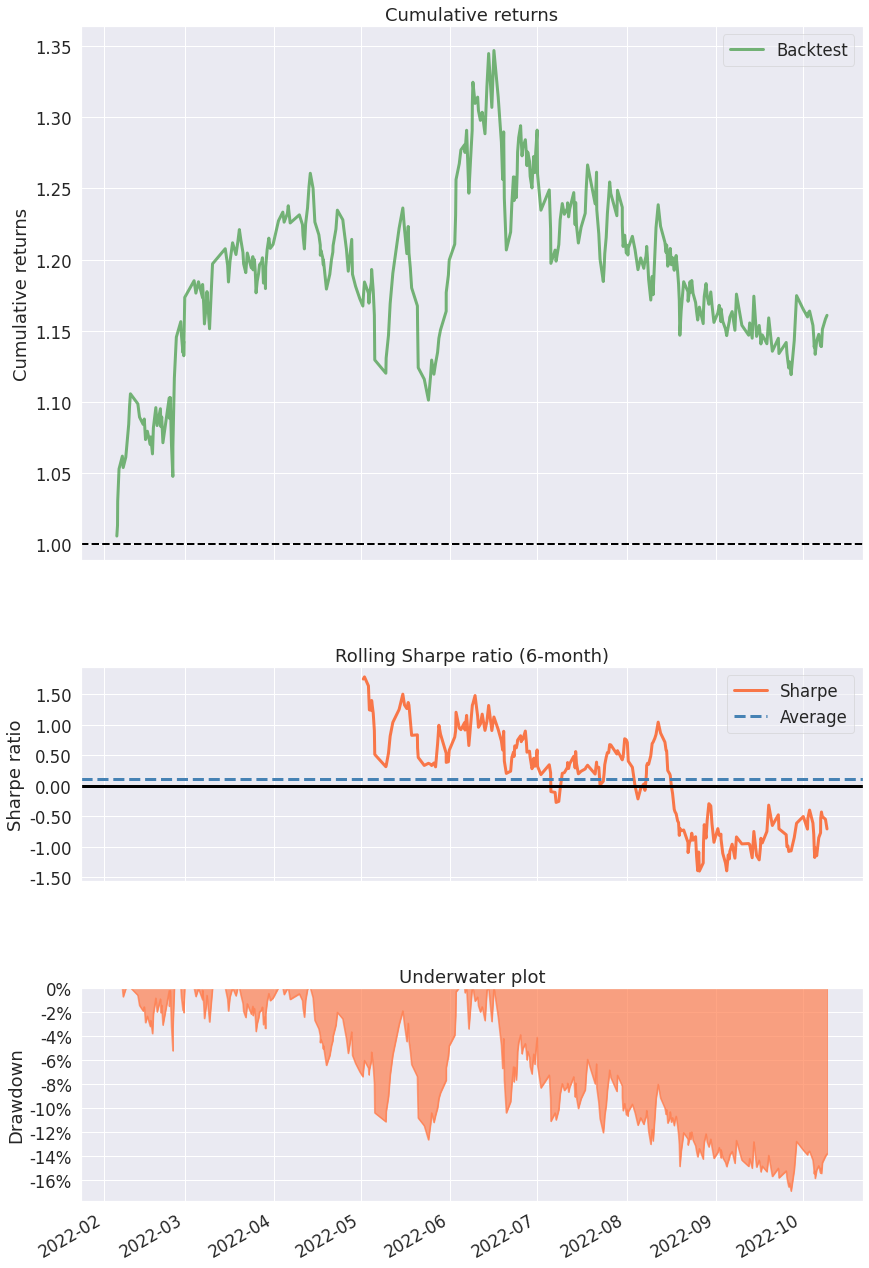

In [17]:
stat_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stat_df = stat_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stat_df['ReturnPct'])

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

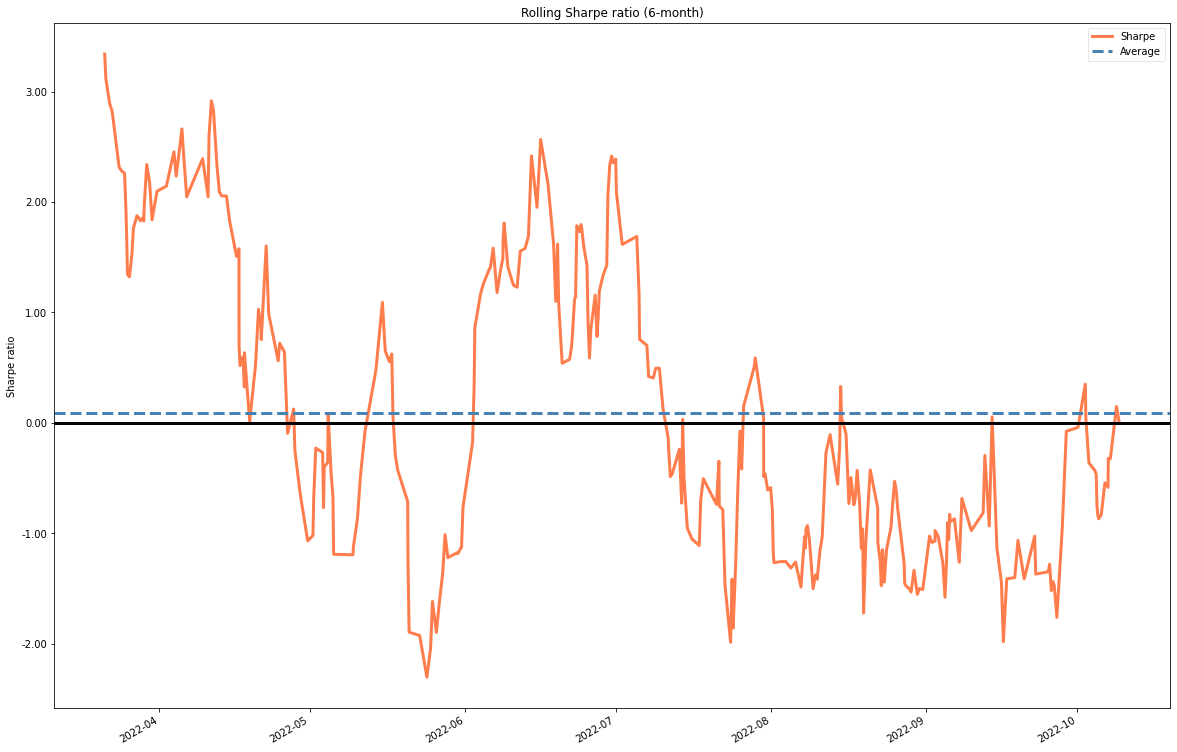

In [18]:
from pyfolio.plotting import plot_rolling_sharpe

plt.figure(figsize=(20, 14))
plot_rolling_sharpe(stat_df['ReturnPct'], rolling_window=21*3)

In [19]:
# Calculating probabilistic Sharpe Ratio on OOS performance
SR_BENCHMARK = 0
psr = probabilistic_sharpe_ratio(stat_df['ReturnPct'], sr_benchmark=SR_BENCHMARK)

print(f"Probabilistic Sharpe Ratio : {psr}")

Probabilistic Sharpe Ratio : 0.7717746082053318


In [21]:
# Attempt to filter with moving average trend filter
# Model performance evaluation on OOS data

from backtesting.lib import resample_apply

pt_sl = [0.7, 0.7]

binance_commission = 0.001

def SMA(array, n):
    return pd.Series(array).rolling(n).mean()

class CCIMetaStrategy(Strategy):
    long_model  = None
    short_model = None

    def init(self):
        super().init()
        self.sma_fast = resample_apply('30min', SMA, self.data.Close, 50 )
        self.sma_slow = resample_apply('30min', SMA, self.data.Close, 200)

    def next(self):
        super().next()

        if self.long_model is None:
            print("Need to supply long side model...")
            return
        if self.short_model is None:
            print("Need to supply short side model...")
            return

        is_up_trend   = False
        is_down_trend = False
        if self.sma_fast[-1]>self.sma_slow[-1]:
            is_up_trend = True
        if self.sma_fast[-1]<self.sma_slow[-1]:
            is_down_trend = True

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        price      = self.data.Close[-1]
        volatility = self.data.volatility_tpsl[-1]

        short_state = []
        for feature in short_features:
            short_state.append(self.data[feature][-1])

        long_state = []
        for feature in long_features:
            long_state.append(self.data[feature][-1])

        # Long case
        if self.long_model is not None and self.data.position[-1]==1 and is_up_trend:
            price_0 = np.exp(np.log(price)+volatility*pt_sl[0])
            price_1 = np.exp(np.log(price)-volatility*pt_sl[1])
            probability = self.long_model.predict_proba([long_state])[0,1]
            size = 1.0
            if probability>=long_trigger_threshold and probability<long_green_threshold:
                size = 0.5
            if probability>=long_green_threshold:
                size=1.0
            if probability>=long_trigger_threshold:
                self.buy(size=size, sl=price_1, tp=price_0)
                #print(f"Long at {price} {round(probability,2)}% SL={price_1} TP={price_0}")

        # Short case
        if self.short_model is not None and self.data.position[-1]==-1 and is_down_trend:
            price_0 = np.exp(np.log(price)+volatility*pt_sl[1])
            price_1 = np.exp(np.log(price)-volatility*pt_sl[0])

            probability = self.short_model.predict_proba([short_state])[0,1]
            size = 1.0
            if probability>=short_trigger_threshold and probability<short_green_threshold:
                size = 0.5
            if probability>=short_green_threshold:
                size=1.0
            if probability>=short_trigger_threshold:
                self.sell(size=size, sl=price_0, tp=price_1)
                #print(f"Short at {price} {round(probability, 2)}% SL={price_0} TP={price_1}")

bt = Backtest(
    eval_df, 
    CCIMetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run(long_model=long_rf, short_model=short_rf)

print(stats)

Start                     2022-02-05 00:02...
End                       2022-10-10 04:03...
Duration                    247 days 04:01:00
Exposure Time [%]                   14.599266
Equity Final [$]              105833627.29886
Equity Peak [$]              107465606.586026
Return [%]                           5.833627
Buy & Hold Return [%]              -53.085939
Return (Ann.) [%]                    8.702742
Volatility (Ann.) [%]                9.565767
Sharpe Ratio                          0.90978
Sortino Ratio                        1.474882
Calmar Ratio                         1.757277
Max. Drawdown [%]                   -4.952402
Avg. Drawdown [%]                   -0.231662
Max. Drawdown Duration       80 days 20:44:00
Avg. Drawdown Duration        1 days 11:10:00
# Trades                                  197
Win Rate [%]                        55.837563
Best Trade [%]                       3.109708
Worst Trade [%]                     -3.604795
Avg. Trade [%]                    

Start date,2022-02-10
End date,2022-10-09
Total months,9
,Backtest
Annual return,30.0%
Cumulative returns,22.8%
Annual volatility,19.3%
Sharpe ratio,1.46
Calmar ratio,2.23
Stability,0.72
Max drawdown,-13.5%


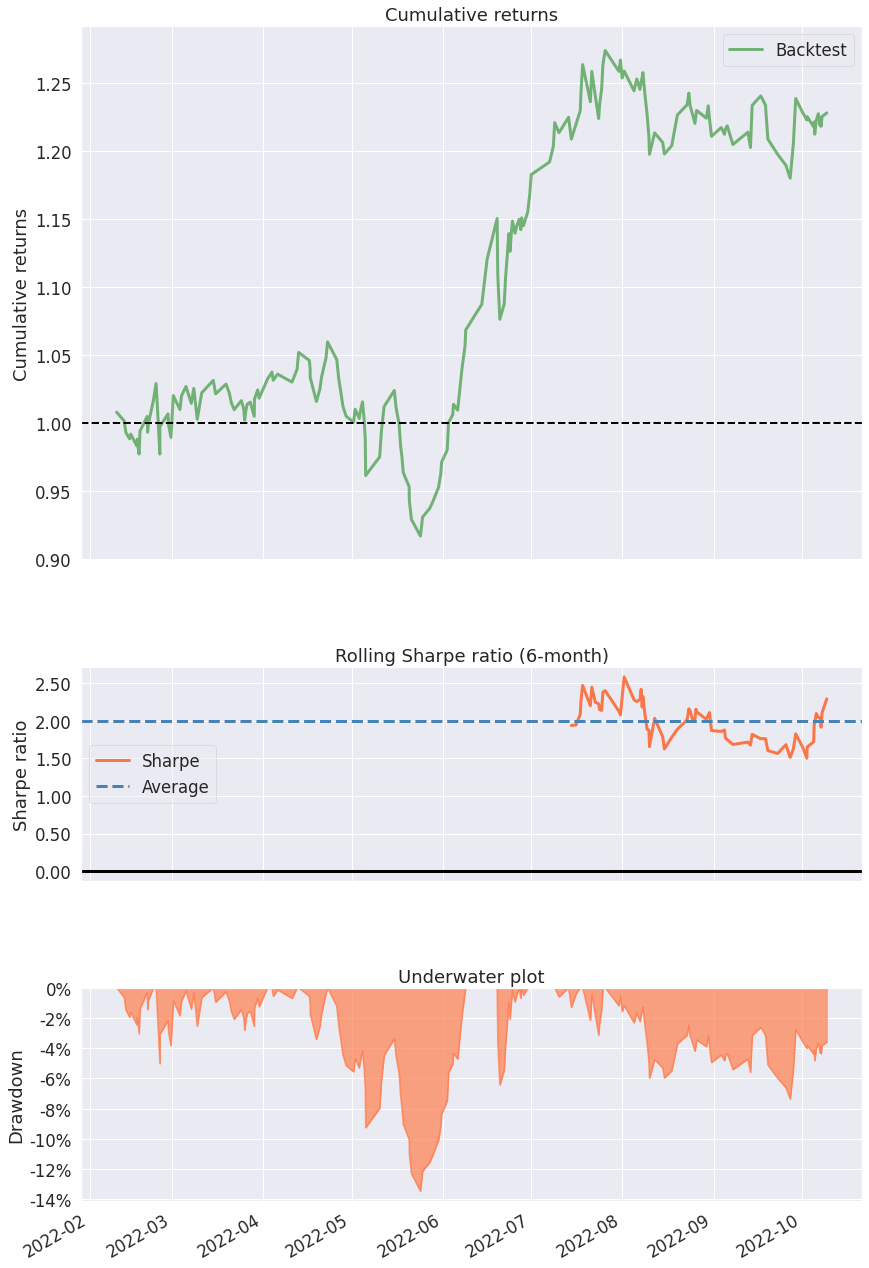

In [22]:
stat_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stat_df = stat_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stat_df['ReturnPct'])

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

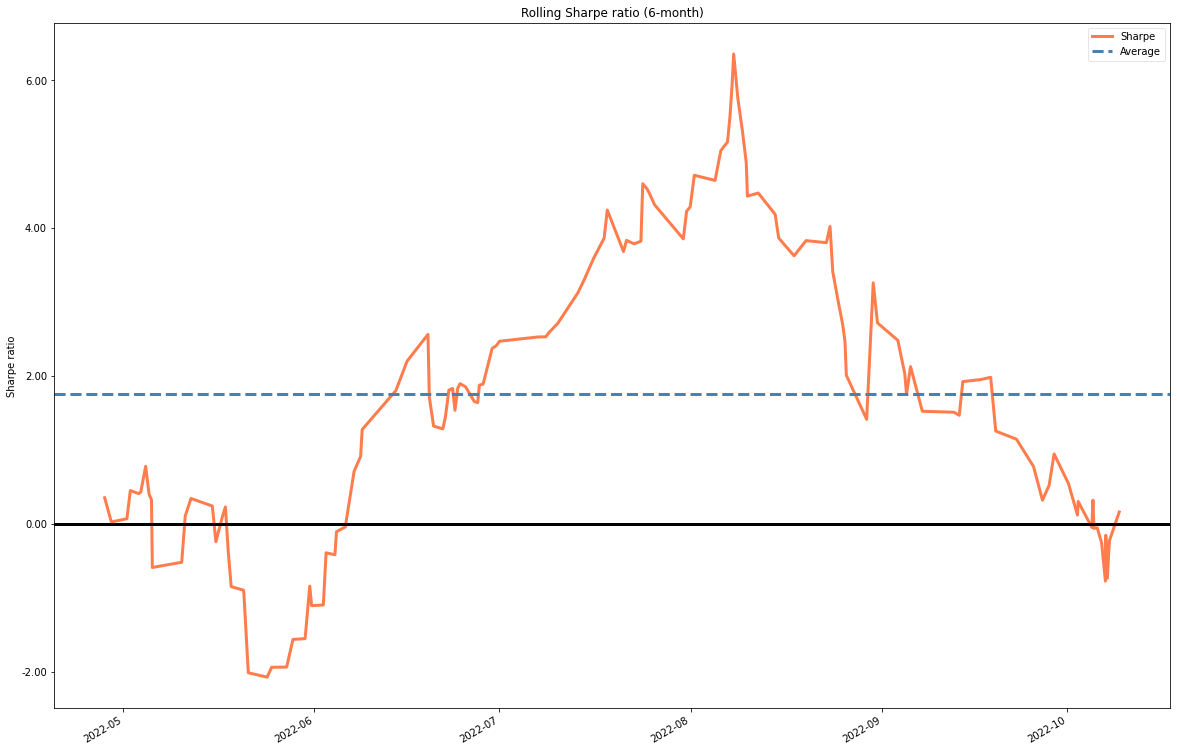

In [23]:
from pyfolio.plotting import plot_rolling_sharpe

plt.figure(figsize=(20, 14))
plot_rolling_sharpe(stat_df['ReturnPct'], rolling_window=21*3)

In [24]:
# Calculating probabilistic Sharpe Ratio on OOS performance
SR_BENCHMARK = 0
psr = probabilistic_sharpe_ratio(stat_df['ReturnPct'], sr_benchmark=SR_BENCHMARK)

print(f"Probabilistic Sharpe Ratio : {psr}")

Probabilistic Sharpe Ratio : 0.8990361475115636
